In [1]:
import json 
import pandas as pd 
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
import matplotlib.gridspec as gridspec
from gensim.models import LdaMulticore


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive 
drive.mount('/content/gdrive') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:

tweets = []
j=0
with open('/content/gdrive/My Drive/Flickr8kData/twitter_data.json') as file:
    for line in file: 
        if line.strip():
            tweets.append(json.loads(line))
        
df_covid = pd.json_normalize(tweets)

In [6]:
df_covid2 = df_covid.loc[df_covid['lang'] == "en"]


In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [12]:
import re
import nltk
from nltk.tokenize import word_tokenize
from string import punctuation 
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer 
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text

def stemming(text):
    text = [ps.stem(word) for word in text]
    return text
    

def clean_tweets(df=df_covid2, tweet_col='text'):
    
    df_copy = df.copy()
    
    df_copy['preprocessed_' + tweet_col] = df_copy[tweet_col].str.lower()
    
    en_stop_words = set(stopwords.words('english') + list(punctuation) + ['AT_USER','URL'])
    extended_stop_words = en_stop_words | \
                        {
                            '&amp;', 'rt',                           
                            'th','co', 're', 've', 'kim', 'daca'
                        }
    user = '@[^\s]+'
    url_re = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'        
    df_copy['preprocessed_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda row: ' '.join([word for word in row.split() if (not word in extended_stop_words) and (not re.match(url_re, word)) and (not re.match(user, word))]))
    
    tokenizer = RegexpTokenizer('[a-zA-Z]\w+\'?\w*')
    df_copy['preprocessed_' + tweet_col]  = df_copy['preprocessed_' + tweet_col].apply(lambda row: tokenizer.tokenize(row))
    df_copy['preprocessed_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda x: stemming(x))
    df_copy['tokenized_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda x: lemmatizer(x))

    return df_copy
  
df_tweets_clean = clean_tweets(df_covid2)


Text(0, 0.5, 'Coherence Score')

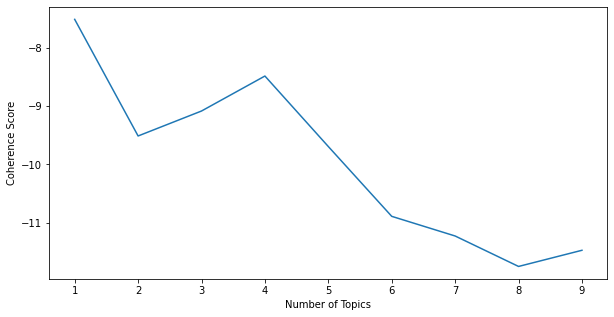

In [13]:

tweets_dictionary = Dictionary(df_tweets_clean.tokenized_text)

# build the corpus i.e. vectors with the number of occurence of each word per tweet
tweets_corpus = [tweets_dictionary.doc2bow(tweet) for tweet in df_tweets_clean.tokenized_text]

# compute coherence
tweets_coherence = []
for nb_topics in range(1,10):
    lda = LdaMulticore(corpus=tweets_corpus,
                                       id2word=tweets_dictionary,
                                       num_topics=nb_topics, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)
    #lda = LdaModel(tweets_corpus, num_topics = nb_topics, id2word = tweets_dictionary, passes=10)
    cohm = CoherenceModel(model=lda, corpus=tweets_corpus, dictionary=tweets_dictionary, coherence='u_mass')
    coh = cohm.get_coherence()
    tweets_coherence.append(coh)

# visualize coherence
plt.figure(figsize=(10,5))
plt.plot(range(1,10),tweets_coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


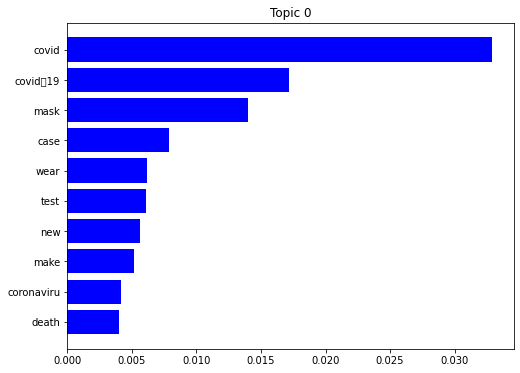

In [16]:
k = 1
import math
import matplotlib.gridspec as gridspec

tweets_lda = LdaModel(tweets_corpus, num_topics = k, id2word = tweets_dictionary, passes=10)

def plot_top_words(lda=tweets_lda, nb_topics=k, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(k))+1,round(math.sqrt(k))+1)
    gs.update(wspace=0.5, hspace=0.5)
    plt.figure(figsize=(20,15))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))
        
plot_top_words()